# Introductory note
<a id='section0'></a>
This is a [Jupyter Notebook](https://jupyter-notebook-beginner-guide.readthedocs.io/en/latest/what_is_jupyter.html) with the purpose of making you familiar with the basic Python-based [Brightway2 LCA framework](https://docs.brightway.dev/en/latest/#) and its various functionalities, all developed by Chris Mutel and colleagues from the Paul Sherrer Institute (PSI).

This tutorial is made for the old version of bw2, and is not meant to handle the new version bw25 (even if the framework remains quite similar). More informations can be found in the [documentation](https://docs.brightway.dev/en/latest/#)

<div class="alert alert-block alert-info">
This notebook is designed to get you started with creating your own project, setting up your database(s) (used as background systems) and simple foreground systems, performing your first impact assessments, analysing your results, and running Monte Carlo simulations in calculation setups.
</div>


<br>

---

The notebook is structured as follows:  

1. [Setup of a project](#section1): *How to set up a project to work in* <br><br>
2. [Database import/setup](#section2): *How to import a database and get it ready for use*<br><br>
3. [My First LCA](#section3): *How to do an LCA on Brightway2*<br><br> 
4. [My second LCA : comparative LCA](#section5): *How to LCA scores*<br><br>
5. [My third LCA : mutliple impact categories](#section4): *LCIA with several impact categories*<br><br>
6. [Basic contribution analysis](#section7): *How to examine the LCA results*<br><br>  
7. [Uncertainties](#section8): *How to do a MonteCarlo simulation in BW*<br><br>  
---

**Outcomes - what are we going to learn?**

By completing this notebook (run it locally on your machine and don't just read the code), we will:
- have understood the basics of the Brightway2 LCA framework
- know how to import/generate/handle datasets in Brightway2
- be able to run simple LCAs (both linearly and in parallel)
- be able to analyse a product system and the results of an LCA
- be able to visualise data in form of tables and figures

<br>

---
Just for clarification, abbreviations used in the markdown cells of this notebook are:

| Abbreviation(s) | Written out |
| --- | --- |
| bw, BW2 | Brightway2 |
| FU | Functional unit |
| LCA | Life cycle assessment |
| LCI | Life cycle inventory |
| LCIA | Life cycle impact assessment |

---

**Recap on LCA**

To make sure we are on the same page, let's recapitulate the basics of LCA, expressed in a single formula (the notation may differ to the one that you are familiar with):

$$h = CBA^{-1}f$$

where:
- $A$... technosphere matrix (dimensions *p x q*)
- $B$... biosphere matrix (dimensions *r x q*)
- $C$... characterisation matrix (dimensions *p x q*)
- $f$... final demand vector (dimensions *p x 1*)
- $h$... characterised inventory matrix (dimensions *1 x 1*)

with the dimensions being:
- *p*... number of products
- *q*... number of activities/processes
- *r*... number of elementary flows

Specific parts of the above formula have distinct names. Since these names are also used in the Brightway2-framework, we will note them down here:
- $f$... demand array
- $A{^-1}f$... supply array
- $BA{^-1}f$... inventory referred sometimes as b
- $CBA{^-1}f$... characterised inventory

<br>


<a id='section1'></a>
# 1. Setup of a project

A project gets instantiated and relevant libraries/modules imported.

## 1.1. Creation of the project and the biosphere database

Import some useful libraries for data vizualisation, scientific computation 

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Import now brightway libraries that are split into sublibraries :
- ``Brightway2-data`` handles storing and searching all data sources (databases, LCIA methods, etc.).
- ``Brightway2-calc`` does LCA calculations.
- ``Brightway2-io`` tools for the import, export, and management of inventory databases and impact assessment methods. LCA calculations.
- ``Brightway2-analyzer`` analyzes input data like databases and methods, as well as the result of LCA calculations.
- ``Brightway2-parameters`` Library for storing, validating, and calculating with parameters.

> it is better to import these libraries separately rather than a brutal ``from brightway2 import *`` since with the upcoming update bw25, this will not work anymore.- 

In [3]:
import bw2data as bd
import bw2io as bi
import bw2calc as bc

Useful tips : one can be interested to check the version of the library imported since there can be some incompatibilities between libraries and databases version.  
Sumup of the compatibility of versions of Ecoinvent and Brightway2:   

In [4]:
# | Ecoinvent version 	| Brightway Version 	| bw2io Version   	|
# |-------------------	|-------------------	|-----------------	|
# | ecoinvent 3.8     	| bw2               	| bw2io 0.8.7     	|
# | ecoinvent 3.9     	| bw2               	| bw2io 0.8.8     	|
# | ecoinvent 3.8     	| bw2.5             	| bw2io 0.9.dev11 	|
# | ecoinvent 3.9     	| bw2.5             	| bw2io 0.9.dev10 	|

The command to show the version of one library is :

In [5]:
print(bi.__version__)

(0, 8, 8)


Let's list the available projects. This project is at the top level of the BW hierarchy. A project is self-contained, with its own copy of data, LCIA methods, calculations, assumptions, and any other data you need. Each project is completely independent of other projects.Projects are saved as subdirectories in the file system.

<img src="images/project.webp"  width="500" style="display: block; margin: 0 auto">

In [5]:
bd.projects

Brightway2 projects manager with 5 objects:
	PB
	TUTO
	default
	demo
	model
Use `projects.report()` to get a report on all projects.

In [6]:
# how to remove a project
# bd.projects.delete_project('TUTO')

We can get more information (installed databases and file sizes) on the individual projects... and also see where they are stored with the following command. (you might need to dig into this folder if any persisting troubles)

In [7]:
bd.projects.dir

'C:\\Users\\TL268686\\AppData\\Local\\pylca\\Brightway3\\default.c21f969b5f03d33d43e04f8f136e7682'

To create a new project or to access an existing one, we type in:

In [8]:
bd.projects.set_current("TUTO") #Creating/accessing the project

Check if our new project is well created:

In [9]:
bd.projects

Brightway2 projects manager with 5 objects:
	PB
	TUTO
	default
	demo
	model
Use `projects.report()` to get a report on all projects.

Look inside the project to know what datases are already imported:

In [10]:
bd.databases

Databases dictionary with 4 object(s):
	biosphere3
	db_user
	ecoinvent 3.9.1_cutoff
	water_bottle

**Continue, or back to [table of contents](#section0)?**
***

## 1.2 Biosphere3 database and LCIA methods

In [11]:
bi.bw2setup() #Importing elementary flows, LCIA methods and some other data

Biosphere database already present!!! No setup is needed


The output tells us that bw2_setup created some very useful things:  
  - Created a database called "biosphere3": this database contains elementary flows (called biosphere exchanges in Brightway2)  
  - **762** impact assessment methods  (with bw2data version 3.8.8)
  
It also created some a `mapping` between the imported exchanges and some integer: more on this later.  

In [12]:
bd.databases

Databases dictionary with 4 object(s):
	biosphere3
	db_user
	ecoinvent 3.9.1_cutoff
	water_bottle

To access a database in Brightway, you use the `Database` initialization method (again, you can type `Database?` for more information - this is the last time I'll mention this.)

In [13]:
bd.Database('biosphere3')

Brightway2 SQLiteBackend: biosphere3

It doesn't actually return anything other than information about the Backend.  
However, there are many properties and functions associated with this database object.

Let's assign the database to a variable:

In [14]:
my_bio = bd.Database('biosphere3')

Let's check the my_bio `type`:

In [15]:
type(my_bio)

bw2data.backends.peewee.database.SQLiteBackend

Let's check its length:

In [16]:
len(my_bio)

4709

If you type `my_bio.` and click on tab, you should get a list of properties and methods associated with database objects. Try this now:

In [17]:
my_bio.       # Type my_bio. and click tab. Have a look at the different properties and objects

SyntaxError: invalid syntax (547212749.py, line 1)

Some of the more basic ones we will be using now are :  
  - `random()` - returns a random activity in the database
  - `get(*valid_exchange_tuple*)` - returns an activity, but you must know the activity key
  - `load()` - loads the whole database as a dictionary.
  - `make_searchable` - allows searching of the database (by default, it is already searchable)
  - `search` - search the database  
  
Lets start with `random`:

In [18]:
my_bio.random()

'Transformation, from bare area (non-use)' (square meter, None, ('natural resource', 'land'))

This returns a biosphere activity, but without assigning it to a variable, there is not much we can do with it directly.  

*Note: It may seem counter-intuitive for elementary *flows* to be considered *activities* in Brightway, but it is no mistake.*

<div class="alert alert-block alert-info">
LCA models are made up of <strong><span style="color:blue">nodes = activities</span></strong> that are linked by <strong><span style="color:blue">edges = exchanges</span></strong>.   

The biosphere activities are the nodes outside the technosphere. Emissions and resource extractions are modelled as exchanges between activities in the technosphere (part of the product system) and these biosphere activities.  
More on this later. 

<img src="images/activity_schema.png"  width="600" style="display: block; margin: 0 auto">

For now, let's assign another random activity to a variable:

In [19]:
random_biosphere = my_bio.random()
random_biosphere

'Ethane, 1,2-dichloro-' (kilogram, None, ('air', 'non-urban air or from high stacks'))

We can get the type of the object that was returned from the database:

In [20]:
type(random_biosphere)

bw2data.backends.peewee.proxies.Activity

The type is an **activity proxy**. Activity proxies allow us to interact with the content of the database. In the journey to and from the database, several translation layers are used:  
<img src="images/data_transition_layers.png" width="200" style="display: block; margin: 0 auto">

> In Brightway, we *almost* always work with `Activity` or `Exchange` objects. 

### Searching for activities

Let's say we are looking for a specific elementary flow, we can use the `search` method of the database (see [here](https://docs.brightwaylca.org/technical/bw2data.html#default-backend-databases-stored-in-a-sqlite-database) for more details on using search):

In [21]:
bd.Database('biosphere3').search('Gold')

['Gold' (kilogram, None, ('water', 'ground-, long-term')),
 'Gold' (kilogram, None, ('natural resource', 'in ground')),
 'Gold' (kilogram, None, ('water',)),
 'Gold' (kilogram, None, ('water', 'surface water')),
 'Gold' (kilogram, None, ('water', 'ground-')),
 'Gold' (kilogram, None, ('water', 'ocean')),
 'Gold, Au 1.4E-4%, in ore' (kilogram, None, ('natural resource', 'in ground')),
 'Gold, Au 7.1E-4%, in ore' (kilogram, None, ('natural resource', 'in ground')),
 'Gold, Au 4.9E-5%, in ore' (kilogram, None, ('natural resource', 'in ground')),
 'Gold, Au 6.7E-4%, in ore' (kilogram, None, ('natural resource', 'in ground')),
 'Gold, Au 4.3E-4%, in ore' (kilogram, None, ('natural resource', 'in ground')),
 'Gold, Au 1.0E-7%, in mixed ore' (kilogram, None, ('natural resource', 'in ground')),
 'Gold, Au 1.8E-4%, in mixed ore' (kilogram, None, ('natural resource', 'in ground')),
 'Gold, Au 9.7E-4%, in mixed ore' (kilogram, None, ('natural resource', 'in ground')),
 'Gold, Au 1.1E-4%, Ag 4.2E-

It is also possible to use "filters" to narrow searches, e.g.

In [22]:
bd.Database('biosphere3').search('carbon dioxide', filter={'categories':'urban', 'name':'fossil'})

Excluding 17 filtered results


['Carbon dioxide, fossil' (kilogram, None, ('air', 'non-urban air or from high stacks')),
 'Carbon dioxide, fossil' (kilogram, None, ('air', 'urban air close to ground')),
 'Carbon dioxide, non-fossil' (kilogram, None, ('air', 'non-urban air or from high stacks')),
 'Carbon dioxide, non-fossil' (kilogram, None, ('air', 'urban air close to ground'))]

The database object is also iterable, allowing "home-made" searches through list comprehensions. This approach is better because one can add as many criteria as wanted to ensure the list comprehension only returns one activity, and then choose it without fear of choosing the wrong one..

In [23]:
[act for act in my_bio if 'Carbon dioxide' in act['name'] and 'fossil' in act['name']]

['Carbon dioxide, non-fossil' (kilogram, None, ('air', 'urban air close to ground')),
 'Carbon dioxide, fossil' (kilogram, None, ('air', 'non-urban air or from high stacks')),
 'Carbon dioxide, non-fossil' (kilogram, None, ('air', 'lower stratosphere + upper troposphere')),
 'Carbon dioxide, non-fossil' (kilogram, None, ('air', 'low population density, long-term')),
 'Carbon dioxide, fossil' (kilogram, None, ('air', 'lower stratosphere + upper troposphere')),
 'Carbon dioxide, non-fossil, resource correction' (kilogram, None, ('natural resource', 'in air')),
 'Carbon dioxide, fossil' (kilogram, None, ('air', 'low population density, long-term')),
 'Carbon dioxide, non-fossil' (kilogram, None, ('air', 'non-urban air or from high stacks')),
 'Carbon dioxide, fossil' (kilogram, None, ('air',)),
 'Carbon dioxide, fossil' (kilogram, None, ('air', 'urban air close to ground')),
 'Carbon dioxide, non-fossil' (kilogram, None, ('air',))]

In [24]:
activity_I_want = [act for act in my_bio if 'Carbon dioxide' in act['name'] 
                                            and 'fossil' in act['name']
                                            and 'non' not in act['name']
                                            and 'urban air close to ground' in str(act['categories'])
                                            ]
activity_I_want

['Carbon dioxide, fossil' (kilogram, None, ('air', 'urban air close to ground'))]

In [25]:
type(activity_I_want)

list

Be careful this is a list and not the activity. So lets pick the first index of the list

In [26]:
activity_I_want = [act for act in my_bio if 'Carbon dioxide' in act['name'] and 'fossil' in act['name'] and 'non' not in act['name'] and 'urban air close to ground' in str(act['categories'])][0]
activity_I_want

'Carbon dioxide, fossil' (kilogram, None, ('air', 'urban air close to ground'))

In [27]:
type(activity_I_want)

bw2data.backends.peewee.proxies.Activity

Let's leave the biosphere database here for now.

### Methods

Importation of biosphere also installed LCIA methods. Let's dig into all these impact categories

In [28]:
bd.methods

Methods dictionary with 762 objects, including:
	('CML v4.8 2016', 'acidification', 'acidification (incl. fate, average Europe total, A&B)')
	('CML v4.8 2016', 'climate change', 'global warming potential (GWP100)')
	('CML v4.8 2016', 'ecotoxicity: freshwater', 'freshwater aquatic ecotoxicity (FAETP inf)')
	('CML v4.8 2016', 'ecotoxicity: marine', 'marine aquatic ecotoxicity (MAETP inf)')
	('CML v4.8 2016', 'ecotoxicity: terrestrial', 'terrestrial ecotoxicity (TETP inf)')
	('CML v4.8 2016', 'energy resources: non-renewable', 'abiotic depletion potential (ADP): fossil fuels')
	('CML v4.8 2016', 'eutrophication', 'eutrophication (fate not incl.)')
	('CML v4.8 2016', 'human toxicity', 'human toxicity (HTP inf)')
	('CML v4.8 2016', 'material resources: metals/minerals', 'abiotic depletion potential (ADP): elements (ultimate reserves)')
	('CML v4.8 2016', 'ozone depletion', 'ozone layer depletion (ODP steady state)')
Use `list(this object)` to get the complete list.

One can load a random method:

In [29]:
bd.methods.random()

('EDIP 2003 no LT', 'eutrophication no LT', 'combined potential no LT')

In [30]:
type(bd.methods.random())

tuple

Of course, a random method is probably not useful except to play around. To find an actual method, one can again use list comprehensions. Let's say I am interested in using the IPCC2013 100 years method:

In [31]:
[m for m in bd.methods if 'EF v3.0 no LT' in str(m)]

[('EF v3.0 no LT', 'acidification no LT', 'accumulated exceedance (AE) no LT'),
 ('EF v3.0 no LT',
  'climate change no LT',
  'global warming potential (GWP100) no LT'),
 ('EF v3.0 no LT',
  'climate change: biogenic no LT',
  'global warming potential (GWP100) no LT'),
 ('EF v3.0 no LT',
  'climate change: fossil no LT',
  'global warming potential (GWP100) no LT'),
 ('EF v3.0 no LT',
  'climate change: land use and land use change no LT',
  'global warming potential (GWP100) no LT'),
 ('EF v3.0 no LT',
  'ecotoxicity: freshwater no LT',
  'comparative toxic unit for ecosystems (CTUe) no LT'),
 ('EF v3.0 no LT',
  'ecotoxicity: freshwater, inorganics no LT',
  'comparative toxic unit for ecosystems (CTUe) no LT'),
 ('EF v3.0 no LT',
  'ecotoxicity: freshwater, metals no LT',
  'comparative toxic unit for ecosystems (CTUe) no LT'),
 ('EF v3.0 no LT',
  'ecotoxicity: freshwater, organics no LT',
  'comparative toxic unit for ecosystems (CTUe) no LT'),
 ('EF v3.0 no LT',
  'energy resou

I am interested in the second of these, and will assign it to a variable. I can will refine my search until there is one element in my list and then choose it by subscripting.  
> *you might have an error here, since the exact name of the method depends on the version of bw. Just adapt the syntax to get the method GWP100 by IPCC 2013*

In [32]:
[m for m in bd.methods if 'IPCC 2013 no LT' in str(m)
                        and 'GWP100' in str(m)]

[('IPCC 2013 no LT',
  'climate change no LT',
  'global warming potential (GWP100) no LT')]

Good, now let's assign it to a variable:

In [33]:
ipcc2013 = [m for m in bd.methods if 'IPCC 2013 no LT' in str(m)
                        and 'GWP100' in str(m)][0]
ipcc2013

('IPCC 2013 no LT',
 'climate change no LT',
 'global warming potential (GWP100) no LT')

Of course, if I know exactly the method I want, and I know the syntax, I can simply type it out

Using ``bd.method()``, we have access to the impact category in BW

In [34]:
ipcc_2013_method = bd.Method(ipcc2013)

In [35]:
type(ipcc_2013_method)

bw2data.method.Method

Again, there are a bunch of methods associated with a method object. You can access these by typing ipcc_2013_method. and clicking tab.  
For example, metadata:

In [36]:
ipcc_2013_method.name

('IPCC 2013 no LT',
 'climate change no LT',
 'global warming potential (GWP100) no LT')

In [37]:
ipcc_2013_method.metadata

{'description': '',
 'filename': 'LCIA_Implementation_3.9.xlsx',
 'unit': 'kg CO2-Eq',
 'abbreviation': 'ipcc-2013-no-ltcg.7962c33963a1191f21e7488df1f998cd',
 'num_cfs': 167}

In [38]:
ipcc_2013_method.metadata['unit']

'kg CO2-Eq'

We can also have a look into the characterization factors, elements of the matrix C. 
>They consist of the key of the *activity = (database name, unique identifier of the activity) and the amount of the CF*

In [39]:
cf = ipcc_2013_method.load()

cf[:10]

[(('biosphere3', 'f9749677-9c9f-4678-ab55-c607dfdc2cb9'), 1),
 (('biosphere3', '6edcc2df-88a3-48e1-83d8-ffc38d31c35b'), 4.0624),
 (('biosphere3', '9afa0173-ecbd-4f2c-9c5c-b3128a032812'), 2.491),
 (('biosphere3', '4cadbc9f-0472-4bb9-a942-df5b90e37878'), 16.40180896),
 (('biosphere3', 'fa0c2bee-8dd9-4f8a-8489-b1f3b43de958'), 1301.27019996),
 (('biosphere3', '818cee9e-231c-4b53-8ed2-47a0001802d5'), 160.09863099),
 (('biosphere3', 'f43b2b80-f5a6-4d31-9980-0754305a978d'), 4804.43907777),
 (('biosphere3', '033d3a16-e1a2-4ce8-8769-f4ea867801ca'), 782.03725986),
 (('biosphere3', '393d0862-04cc-45ae-8d08-9dc2a4461b35'), 137.56020393),
 (('biosphere3', '468bebea-17ee-49d3-b11d-c603d91c67c8'), 0.89826217)]

**Back to [table of contents](#section0)?**
***

<a id='section2'></a>
# 2. Database import/setup

<a id='section21'></a>
## 2.1 Importing ecoinvent

LCA draws on a lot of background data. Those can be found in numerous databases, for instance ecoinvent. We can check which databases are available in the current project with the following command:

To import ecoinvent, you need a license and download the ecoinvent file locally. Then can import it with the following command

In [43]:
if 'ecoinvent 3.9_cutoff' in bd.databases:
    print("Database has already been imported.")
else:
    # mind that the ecoinvent file must be unzipped; then: path to the datasets subfolder
    fp = r"C:\Users\User\Documents\Ecoinvent 3.9\ecoinvent 3.9.1_cutoff_ecoSpold02\datasets" # the "r" makes sure that the path is read as a string - especially useful when you have spaces in your string
    ei = bi.SingleOutputEcospold2Importer(fp, 'ecoinvent 3.9.1_cutoff') 
    ei.apply_strategies() #apply functions to normalize the flows, turn into a adequate format and match all the properties of the flows (name, unit, reference product, location...)
    ei.statistics() #to check if some flows have no match
    ei.write_database() #regestire the database

Extracting XML data from 21238 datasets
Extracted 21238 datasets in 153.43 seconds
Applying strategy: normalize_units
Applying strategy: update_ecoinvent_locations
Applying strategy: remove_zero_amount_coproducts
Applying strategy: remove_zero_amount_inputs_with_no_activity
Applying strategy: remove_unnamed_parameters
Applying strategy: es2_assign_only_product_with_amount_as_reference_product
Applying strategy: assign_single_product_as_activity
Applying strategy: create_composite_code
Applying strategy: drop_unspecified_subcategories
Applying strategy: fix_ecoinvent_flows_pre35
Applying strategy: drop_temporary_outdated_biosphere_flows
Applying strategy: link_biosphere_by_flow_uuid
Applying strategy: link_internal_technosphere_by_composite_code
Applying strategy: delete_exchanges_missing_activity
Applying strategy: delete_ghost_exchanges
Applying strategy: remove_uncertainty_from_negative_loss_exchanges
Applying strategy: fix_unreasonably_high_lognormal_uncertainties
Applying strategy:

Writing activities to SQLite3 database:


21238 datasets
674593 exchanges
0 unlinked exchanges
  


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:50


Title: Writing activities to SQLite3 database:
  Started: 04/22/2024 15:00:58
  Finished: 04/22/2024 15:01:49
  Total time elapsed: 00:00:50
  CPU %: 97.20
  Memory %: 19.49
Created database: ecoinvent 3.9.1_cutoff


In [49]:
bd.databases

Databases dictionary with 3 object(s):
	biosphere3
	ecoinvent 3.9.1_cutoff
	water_bottle

In [50]:
len(bd.Database("ecoinvent 3.9.1_cutoff"))

21238

Let's dig into our new database

In [51]:
act_random = bd.Database("ecoinvent 3.9.1_cutoff").random()
act_random

'nylon 6 production' (kilogram, RoW, None)

Let's assign this database to one variable

In [52]:
db_background = bd.Database("ecoinvent 3.9.1_cutoff")

To delete a database, here is the syntax:

In [53]:
# del bd.databases['ecoinvent 3.9.1_cutoff']
# bd.databases

You might also be interesting in importing another free database the US LCI built with Input/Output tables (macroeconomic data), but it requires the last update of BW : brightway25. A installation file plus the data have been given, with all the required libraries, if you want to use it.

## 2.2 Importing a dataset from Excel

In addition to the import of a standard background database and the manual database creation (see below), we can also import data from various file types, one of them being Excel. This works relatively smoothly, provided the Excel workbook is created correctly. In the following, we import a flawless dataset. 
>**This is the easiest way to create your own foreground data in Brightway**

However, if you are interested in debugging common issues that occur during import, have a look [here](https://github.com/PoutineAndRosti/Brightway-Seminar-2017/blob/master/Day%201%20PM/Data%20IO.ipynb). 

The used Excel file here was adapted from this source, and should work immediately. Another way for importing an, now unknown, Excel file can be found [here](https://nbviewer.jupyter.org/urls/bitbucket.org/cmutel/brightway2/raw/default/notebooks/IO%20-%20importing%20an%20Excel%20file.ipynb). But here we'll stick to the first approach:

In [54]:
imp = bi.ExcelImporter(os.path.join("excel_importer_example_EI391.xlsx"))
imp.apply_strategies()
imp.match_database(fields=('name', 'unit', 'location'))
imp.match_database('ecoinvent 3.9.1_cutoff', fields=('name', 'unit', 'location', 'reference product'))
imp.statistics()

C:\Users\TL268686\AppData\Local\anaconda3\envs\cours\Lib\site-packages\openpyxl\worksheet\_read_only.py:81: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


Extracted 1 worksheets in 0.06 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_list
Applied 16 strategies in 19.50 seconds
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
2 datasets
7 exchanges
0 unlinked exchanges
  


(2, 7, 0)

if you have any unlinked exchanges. One way to visualize the mismatching errors is to create an excel:

In [1]:
# imp.write_excel()

If no unlinked exchanges, we can register the database: Having imported the data, we also need to write it to a database to save it:

In [79]:
imp.write_database()

Writing activities to SQLite3 database:
0% [##] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 04/22/2024 10:46:21
  Finished: 04/22/2024 10:46:21
  Total time elapsed: 00:00:00
  CPU %: 0.00
  Memory %: 1.86
Created database: water_bottle


In [80]:
bd.databases

Databases dictionary with 3 object(s):
	biosphere3
	ecoinvent 3.9.1_cutoff
	water_bottle

You can check the content of the database with the following code :

In [81]:
db_foreground = bd.Database("water_bottle")
for act in db_foreground:
    print(act)

'water bottle production' (unit, CH, None)
'Drinking water from a bottle' (liter, CH, None)


**Continue, or back to [table of contents](#section0)?**
***

<div class="alert alert-block alert-info">
<b>Tip:</b> Another technique would be to create your foreground database on Activity browser, save it in your projects and use it in Brightway2 (or export it as an excel file)
</div>

Okay, now that we have our background data (be it manually created or imported from an existing database), it's time to model our foreground system!

**Continue, or back to [table of contents](#section0)?**
***

<a id='section22'></a>
## 2.3 Database selection and a first look at activities

Now we'll explore more what are really activities and what it contains (spoil : exchanges)

### LCI activities

<div class="alert alert-block alert-info">
When dealing with <strong>background or foreground databases</strong>, activities refers to <strong>intermediary flows</strong> and are modelled in BW as nodes "within the technosphere" and will be part of the technosphere matrix A. For the <strong>biosphere database</strong>, activities refers to the <strong>elementary flows</strong>, and will be part of the biosphere matrix B.

All theses activities are made of exchanges that consists of **inputs and outputs** which could be different type : 
- biosphere : consumption of resource or emissions,
- technosphere process, 
- production : output amount

</div>

There are different ways to get access to an activity. Let's use the `random()` method for now to explore a random activity in the forwast database.

In [55]:
db_background = bd.Database("ecoinvent 3.9.1_cutoff")
random_act = db_background.random()
random_act

'market for transport, freight, lorry with reefer, freezing' (ton kilometer, GLO, None)

To see what is stored in an activity object, let's convert our random act in a dictionary. There are a lot of metadata contained in an activity !

In [56]:
random_act.as_dict()

{'comment': "This is a market activity. Each market represents the consumption mix of a product in a given geography, connecting suppliers with consumers of the same product in the same geographical area. Markets group the producers and also the imports of the product (if relevant) within the same geographical area. They also account for transport to the consumer and for the losses during that process, when relevant.\nThis is the market for  'transport, freight, lorry with reefer, freezing', in the Global geography.\nThis market contains no transport or losses, as they are irrelevant for the delivered product.\nThis is delivering the service of transportation of 1 metric ton across the distance of 1 km. This service includes the transport of reefer (refrigerated container) by a lorry (truck with semi-trailer). The vehicles used are a combination of lorries with different emission classes (EURO3, 4, 5, 6) and different size (16-32 metric tonnes and >32 metric tonnes). The lifetime capac

Notice one important thing: **no exchanges**!  
Indeed, the exchanges and the activities are stored in two different tables of the `databases.db` database.  
It is possible, however, to iterate through the exchanges of the activities.

### LCI exchanges

**`Exchanges`** are the edges between nodes.

These can be an edge:  
  - between two activities within the technosphere (an element $a_{ij}$ of matrix $A$)  
  - between an activity in the technosphere and an activity in the biosphere (an element $b_{kj}$ of the biosphere matrix $B$).

One can iterate through **all** exchanges that have a given activity as `output`

In [57]:
random_act

'market for transport, freight, lorry with reefer, freezing' (ton kilometer, GLO, None)

In [58]:
for exc in random_act.exchanges():
    print(exc)

Exchange: 1.0 ton kilometer 'market for transport, freight, lorry with reefer, freezing' (ton kilometer, GLO, None) to 'market for transport, freight, lorry with reefer, freezing' (ton kilometer, GLO, None)>
Exchange: 1.0 ton kilometer 'transport, freight, lorry with reefer, freezing' (ton kilometer, GLO, None) to 'market for transport, freight, lorry with reefer, freezing' (ton kilometer, GLO, None)>


One can also iterate through subsets of the exchanges:  
  - **Technosphere** exchanges: exchanges linking to other activities in the technosphere, `activity.technosphere()`  
  - **Biosphere** exchanges: AKA elementary flows, linking to activities in the biosphere database `activity.biosphere()`  
  - **Production** exchange: the reference flow of the activity `activity.production`  

Let's assign a **technosphere exchange** to a variable to learn more about it: 

:point_right: *you might have an error here, if your random activity has no exchanges that come from the technosphere. Just try with another one*

In [59]:
random_techno_exchange = [exc for exc in random_act.technosphere()][0]
random_techno_exchange

Exchange: 1.0 ton kilometer 'transport, freight, lorry with reefer, freezing' (ton kilometer, GLO, None) to 'market for transport, freight, lorry with reefer, freezing' (ton kilometer, GLO, None)>

In [60]:
type(random_techno_exchange)

bw2data.backends.peewee.proxies.Exchange

Again, the type is a proxy (refer to the diagram above about the different translation layers).
This type has a few interesting properties

In [61]:
# Amount, or weight of the edge
random_techno_exchange.amount

1.0

In [62]:
# Activity the exchange stems from
random_techno_exchange.input

'transport, freight, lorry with reefer, freezing' (ton kilometer, GLO, None)

In [63]:
# Activity the exchange terminates in
random_techno_exchange.output

'market for transport, freight, lorry with reefer, freezing' (ton kilometer, GLO, None)

In [64]:
# Exchange as a dictionary
random_techno_exchange.as_dict()

{'flow': '3d8a88cb-02ca-48f4-857e-18e68995d78d',
 'type': 'technosphere',
 'name': 'transport, freight, lorry with reefer, freezing',
 'classifications': {'CPC': ['65111: Road transport services of freight by refrigerator vehicles']},
 'production volume': 0.0,
 'properties': {'carbon allocation': {'amount': 0.0, 'unit': 'kg'},
  'carbon content': {'amount': 0.0, 'unit': 'dimensionless'},
  'price': {'amount': 0.02163296280705376, 'unit': 'EUR2005'}},
 'activity': '7d878db7-895b-530e-bf1f-31b15876688c',
 'unit': 'ton kilometer',
 'amount': 1.0,
 'uncertainty type': 0,
 'loc': 1.0,
 'input': ('ecoinvent 3.9.1_cutoff', 'bd225503d9c1cc69dd3f645ee58b33d5'),
 'output': ('ecoinvent 3.9.1_cutoff', '18dfb38e946379168f00194fba11e359')}

<div class="alert alert-block alert-danger">

:warning: Sign Convention in BW :warning:
- for biosphere flows : a positivive value means emissions to the natural environment for [air], [soil], and [water] categories, and consumtion of resources from their environment for [natural resource] category
- for technosphere : negative values represent the consumption of products, while positive values represent the production of products

For the specific case of End of Life treatment with wastes, reference product is -1 meaning 1kg is treated (or consumed). Thus, exchanges flows of wastes are also negatives. See this [discussion](https://stackoverflow.com/questions/68133565/negative-production-for-end-of-life-treatment-process)

<a id='section3'></a>
# 3 My first LCA

You have now a sufficient knowledge to perform and understand a LCA in BW.
<div class="alert alert-block alert-info">
Brightway has a so-called LCA object, instantiated using : 

*LCA({reference flow : amount}, impact category)*

The only required argument is a **functional unit, described by a dictionary with keys = activities and values = amounts**  
A second argument that is often passed is an LCIA method, passed using the method tuple. 

## 3.1. General syntax of LCA calculations

Let's create our first LCA object using our random activity

In [65]:
random_act = db_background.random()
random_act

'nutrient supply from poultry manure, fresh' (kilogram, GLO, None)

Get also one impact category. :point_right: *again, depending on the version of your ecoinvent you might need to change the exact name of the method. For instance, IPCC2021 was not already implemented in BW in the 3.8 ecoinvent version*

In [66]:
ipcc2021 = [m for m in bd.methods if 'GWP100' in str(m) and 'IPCC 2021 no LT' in str(m) and 'climate change no LT' in str(m)][0]
ipcc2021

('IPCC 2021 no LT',
 'climate change no LT',
 'global warming potential (GWP100) no LT')

The actual LCA class (``bw2calc.LCA``) is more of a coordinator then an accountant, as the matrix builder is doing much of the data manipulation.  

The lca class only has to do the following:
- Translate the functional unit into a demand array
- Find the right parameter arrays, and ask matrix builder for matrces $A$ and $B$
- Solve the linear system $Ax = B$ to get the LCI (b matrix)
- Multiply the result by the LCIA CFs : $h=Cb$

In [67]:
myFirstLCA_quick = bc.LCA({random_act:1}, ipcc2021)

We can already get some info. For instance we have acess to the demand array f

In [68]:
myFirstLCA_quick.demand

{'nutrient supply from poultry manure, fresh' (kilogram, GLO, None): 1}

In [69]:
myFirstLCA_quick.method

('IPCC 2021 no LT',
 'climate change no LT',
 'global warming potential (GWP100) no LT')

In [70]:
myFirstLCA_quick.lci()    # Builds matrices, solves the system, generates an LCI matrix.
myFirstLCA_quick.lcia()   # Characterization, i.e. the multiplication of the elements 
                          # of the LCI matrix with characterization factors from the chosen method
myFirstLCA_quick.score    # Returns the score, i.e. the sum of the characterized inventory

0.15122348279922498

In [71]:
bd.Method(ipcc2021).metadata['unit']

'kg CO2-Eq'

An example on how to print the score

In [72]:
print("The score to produce 1kg of {} is {:.3f} {}".format(random_act['name'], myFirstLCA_quick.score, bd.Method(ipcc2021).metadata['unit']))

The score to produce 1kg of nutrient supply from poultry manure, fresh is 0.151 kg CO2-Eq


**Back to [table of contents](#section0)?**
***

<a id='section4'></a>
# 4. My second LCA: Comparative LCA

Now, let's compare the impacts of two activities : the production of 1kWh of wind turbine and hydro in Switzerland  

In [73]:
wind = [act for act in db_background if "wind" in act['name']
        and "<1MW" in act['name'] 
        and "kilowatt hour" in act['unit']
        and 'CH' in act['location']][0]
wind

'electricity production, wind, <1MW turbine, onshore, renewable energy products' (kilowatt hour, CH, None)

In [74]:
[act for act in db_background if "hydro" in act['name'] and "river" in act['name'] and "CH" in act['location']]

['electricity, high voltage, hydro, run-of-river, import from France' (kilowatt hour, CH, None),
 'electricity production, hydro, run-of-river, renewable energy products' (kilowatt hour, CH, None),
 'electricity production, hydro, run-of-river' (kilowatt hour, CH, None),
 'hydropower plant construction, run-of-river' (unit, CH, None),
 'electricity, high voltage, hydro, run-of-river, import from France, renewable energy products' (kilowatt hour, CH, None)]

In [75]:
hydro = [act for act in db_background if "electricity production, hydro, run-of-river" in act['name'] 
                     and "CH" in act['location']
                     and "kilowatt hour" in act['unit']
                     ][0]
hydro

'electricity production, hydro, run-of-river' (kilowatt hour, CH, None)

Let's also compare these according to their carbon footprint as measured with the IPCC method we already selected above:

### One at a time approach:

In [76]:
windLCA = bc.LCA({wind:1}, ipcc2021)
windLCA.lci()
windLCA.lcia()
windLCA.score

0.022166620701935952

In [77]:
hydroLCA = bc.LCA({hydro:1}, ipcc2021)
hydroLCA.lci()
hydroLCA.lcia()
hydroLCA.score

0.003610158962011888

Do one "delta" LCA:

In [78]:
deltaLCA = bc.LCA({wind:1, hydro:-1}, ipcc2021)
deltaLCA.lci()
deltaLCA.lcia()
deltaLCA.score

0.018556461739924052

Simple plot results using ``matplotlib.pyplot`` (if installed have a look at ``seaborn`` library for good-looking display and advanced visualization)

First store it in a nice DataFrame using a dictionnary of the results (several ways of defining a dataframe are possible, see [documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html))

In [79]:
df_results = pd.DataFrame(index=[bd.Method(ipcc2021).name[2]], data={"wind": [windLCA.score], "hydro": [hydroLCA.score]})
df_results

,wind,hydro
global warming potential (GWP100) no LT,0.022167,0.00361


Let's plot these results with a simple histogram diagram

The easy and immediate way:

<Axes: >

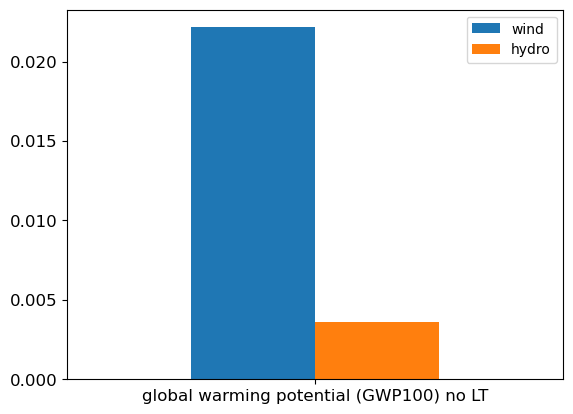

In [80]:
df_results.plot(rot=0, kind='bar', fontsize=12) #plot of a bar diagram, with fonsizen rotation and transparency features


with seaborn library for nice colors (require to have it installed already) + a few useful features

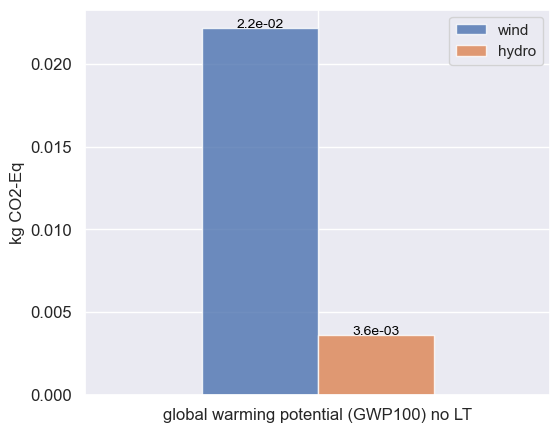

In [81]:
import seaborn as sns
sns.set()
sns.set_style("darkgrid")
colors = sns.color_palette('colorblind')
fig, axes = plt.subplots(figsize=(6,5))
df_results.plot(ax=axes, rot=0, kind='bar', alpha=0.8, fontsize=12) #plot of a bar diagram, with fonsizen rotation and transparency features
plt.ylabel(bd.Method(ipcc2021).metadata['unit'])

#add each score of components    
for bar in axes.patches:
    axes.text(# Put the text in the middle of each bar. get_x returns the start, so we add half the width to get to the middle.
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + bar.get_y(),# Vertically, add the height of the bar to the start of the bar, along with the offset.
            str('{:.1e}'.format(bar.get_height())),# This is actual value we'll show.
            ha='center',# Center the labels and style them a bit.
            color='black',
            alpha=1,
            size=10,
        )

**Back to [table of contents](#section0)?**
***

<a id='section5'></a>
# 5. My third LCA - Multiple impact categories

Say we want to evaluate the indicator results for our randomAct for all EF v3 categories (with long-term emissions).

In [82]:
# Make a list of all impact method names (tuples):
list_methods = [method for method in bd.methods if "EF v3.0" in str(method) 
        and "no LT" not in str(method)
        and "EN15804" not in str(method)]
list_methods

[('EF v3.0', 'acidification', 'accumulated exceedance (AE)'),
 ('EF v3.0', 'climate change', 'global warming potential (GWP100)'),
 ('EF v3.0', 'climate change: biogenic', 'global warming potential (GWP100)'),
 ('EF v3.0', 'climate change: fossil', 'global warming potential (GWP100)'),
 ('EF v3.0',
  'climate change: land use and land use change',
  'global warming potential (GWP100)'),
 ('EF v3.0',
  'ecotoxicity: freshwater',
  'comparative toxic unit for ecosystems (CTUe)'),
 ('EF v3.0',
  'ecotoxicity: freshwater, inorganics',
  'comparative toxic unit for ecosystems (CTUe)'),
 ('EF v3.0',
  'ecotoxicity: freshwater, metals',
  'comparative toxic unit for ecosystems (CTUe)'),
 ('EF v3.0',
  'ecotoxicity: freshwater, organics',
  'comparative toxic unit for ecosystems (CTUe)'),
 ('EF v3.0',
  'energy resources: non-renewable',
  'abiotic depletion potential (ADP): fossil fuels'),
 ('EF v3.0',
  'eutrophication: freshwater',
  'fraction of nutrients reaching freshwater end compartmen

Simplest way: for loop, using `switch method`

In [83]:
random_act = db_background.random()
random_act

'treatment of inert waste, inert material landfill' (kilogram, RoW, None)

In [84]:
myThirdLCA = bc.LCA({random_act:1}, list_methods[0]) # Do LCA with one impact category
myThirdLCA.lci()
myThirdLCA.lcia()
for category in list_methods:
    myThirdLCA.switch_method(category)
    myThirdLCA.lcia()
    print("Score is {:f} {} for category {}".format(myThirdLCA.score, 
                                                 bd.Method(category).metadata['unit'],
                                                 bd.Method(category).name[1])
          )

Score is -0.000046 mol H+-Eq for category acidification
Score is -0.006347 kg CO2-Eq for category climate change
Score is -0.000003 kg CO2-Eq for category climate change: biogenic
Score is -0.006340 kg CO2-Eq for category climate change: fossil
Score is -0.000004 kg CO2-Eq for category climate change: land use and land use change
Score is -0.135481 CTUe for category ecotoxicity: freshwater
Score is -0.050722 CTUe for category ecotoxicity: freshwater, inorganics
Score is -0.080786 CTUe for category ecotoxicity: freshwater, metals
Score is -0.003973 CTUe for category ecotoxicity: freshwater, organics
Score is -0.152531 MJ, net calorific value for category energy resources: non-renewable
Score is -0.000001 kg P-Eq for category eutrophication: freshwater
Score is -0.000018 kg N-Eq for category eutrophication: marine
Score is -0.000188 mol N-Eq for category eutrophication: terrestrial
Score is -0.000000 CTUh for category human toxicity: carcinogenic
Score is 0.000000 CTUh for category human

> if you are bored by these time-consuming syntax, you could turn it into a function, and use only the function. (you could also use already helpers from other libraries like ``lca_algebraic`` to find activities, parametrieze inventory, plot multi impact categories results...)

one example of such function for multi impact categories, would be :

In [85]:
def multiLCA(activity, list_methods):
    results = {}
    LCA = bc.LCA({activity:1}, list_methods[0]) # Do LCA with one impact category
    LCA.lci()
    LCA.lcia()
    for category in list_methods:
        LCA.switch_method(category)
        LCA.lcia()
        results[category[1]] = LCA.score
    return results

In [86]:
multiLCA(random_act, list_methods)

{'acidification': -4.579082729194765e-05,
 'climate change': -0.006346542311180513,
 'climate change: biogenic': -3.0281441579913354e-06,
 'climate change: fossil': -0.006339786299942504,
 'climate change: land use and land use change': -3.727867080017423e-06,
 'ecotoxicity: freshwater': -0.13548056883497672,
 'ecotoxicity: freshwater, inorganics': -0.05072208758488756,
 'ecotoxicity: freshwater, metals': -0.08078583488582138,
 'ecotoxicity: freshwater, organics': -0.003972646364267772,
 'energy resources: non-renewable': -0.15253123930160956,
 'eutrophication: freshwater': -5.060404430088058e-07,
 'eutrophication: marine': -1.760842122064742e-05,
 'eutrophication: terrestrial': -0.0001883826511369472,
 'human toxicity: carcinogenic': -2.731403019635433e-12,
 'human toxicity: carcinogenic, inorganics': 0.0,
 'human toxicity: carcinogenic, metals': -1.3232110821138502e-12,
 'human toxicity: carcinogenic, organics': -1.4081919375215826e-12,
 'human toxicity: non-carcinogenic': -7.3823485

Now if we want to compare the steel and copper for all categories and put it into a nice panda Dataframe, we need at first to store the results with a dictionnary

In [87]:
results_wind = multiLCA(wind, list_methods)
results_hydro = multiLCA(hydro, list_methods)

#Gather the results in one single dictionnary
results = {"wind": list(results_wind.values()), 'hydro': list(results_hydro.values())}
results

{'wind': [0.00013822771566907244,
  0.022918072345782668,
  3.5729138404924236e-05,
  0.02286271530658965,
  1.9627900788091647e-05,
  0.9439139984384176,
  0.09336366168344173,
  0.8427395210936801,
  0.007810815661295968,
  0.2628216740913375,
  1.0303594935499372e-05,
  2.719932976016048e-05,
  0.00024923572656859245,
  1.7378108044359685e-10,
  0.0,
  1.330214996583468e-10,
  4.075958078525004e-11,
  1.1601219897233804e-09,
  2.4352336651356e-10,
  8.854929502836908e-10,
  3.4769957008969566e-11,
  0.0010131317334081244,
  0.737925096594787,
  6.72635259796479e-07,
  3.088590813373597e-10,
  2.0183198999873376e-09,
  9.796635996142986e-05,
  0.01164493488242198],
 'hydro': [1.565538771368376e-05,
  0.003696950582575077,
  4.476841337276129e-06,
  0.0036911781820154546,
  1.2955592223460293e-06,
  0.07390803262230149,
  0.009009538501610681,
  0.0641427841893126,
  0.0007557099313781953,
  0.03222353660326234,
  8.469111092056672e-07,
  5.274468244238801e-06,
  5.559449591365348e-05

In [88]:
# # the classic way
# results = {'hydro':[], "wind":[]}
# multiLCA_hydro = bc.LCA({hydro:1}, list_methods[0]) # Do LCA with one impact category
# multiLCA_hydro.lci()
# multiLCA_hydro.lcia()
# multiLCA_wind = bc.LCA({wind:1}, list_methods[0]) # Do LCA with one impact category
# multiLCA_wind.lci()
# multiLCA_wind.lcia()
# for category in list_methods:
#     multiLCA_hydro.switch_method(category)
#     multiLCA_hydro.lcia()
#     multiLCA_wind.switch_method(category)
#     multiLCA_wind.lcia()    
#     results["hydro"].append(multiLCA_hydro.score) #we add at each impact cateogry the score
#     results["wind"].append(multiLCA_wind.score) #we add at each impact cateogry the score
    

Put it in a nice Dataframe : but first, let's define also short names for the category, would be prettier !

In [89]:
short_names =  ['AC','CC','CC (biogenic)','CC (fossil fuels)','CC(land use)','ECOTOX','ECOTOX, inorg','ECOTOX, metals','ECOTOX, org','ADP, fossil fuels','EP freshwater (P)','EP marine (N)','EP terrestrial','HTOX_c','HTOX_c inorg','HTOX_c, metals','HTOX_c, org','HTOX_nc','HTOX_nc, inorg','HTOX_nc, metals','HTOX_nc, org','IR','LU','ADP, ultimate reserves','ODP','PM','POF','WU']

In [90]:
df_results = pd.DataFrame(index= short_names, data = results)
df_results

,wind,hydro
AC,1.382277e-04,1.565539e-05
CC,2.291807e-02,3.696951e-03
CC (biogenic),3.572914e-05,4.476841e-06
CC (fossil fuels),2.286272e-02,3.691178e-03
CC(land use),1.962790e-05,1.295559e-06
ECOTOX,9.439140e-01,7.390803e-02
"ECOTOX, inorg",9.336366e-02,9.009539e-03
"ECOTOX, metals",8.427395e-01,6.414278e-02
"ECOTOX, org",7.810816e-03,7.557099e-04
"ADP, fossil fuels",2.628217e-01,3.222354e-02


You can even generate beautiful heatmaps like this in a relatively easy way, see example notebook [here](https://github.com/brightway-lca/brightway2/blob/master/notebooks/Using%20calculation%20setups.ipynb) 

<img src="images/multiLCA_heatmap.JPG">

Briefly, here is the syntax to plot such heatmap

In [91]:
df_norm = (df_results.T / df_results.T.loc['wind']) #normalizaton with the results from the activity wind
df_norm

,AC,CC,CC (biogenic),CC (fossil fuels),CC(land use),ECOTOX,"ECOTOX, inorg","ECOTOX, metals","ECOTOX, org","ADP, fossil fuels",...,"HTOX_nc, inorg","HTOX_nc, metals","HTOX_nc, org",IR,LU,"ADP, ultimate reserves",ODP,PM,POF,WU
wind,1.000000,1.000000,1.000000,1.00000,1.000000,1.0000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
hydro,0.113258,0.161312,0.125299,0.16145,0.066006,0.0783,0.096499,0.076112,0.096752,0.122606,...,0.138478,0.039341,0.036944,0.230815,-0.010368,0.024474,0.130642,0.228432,0.193071,0.094292


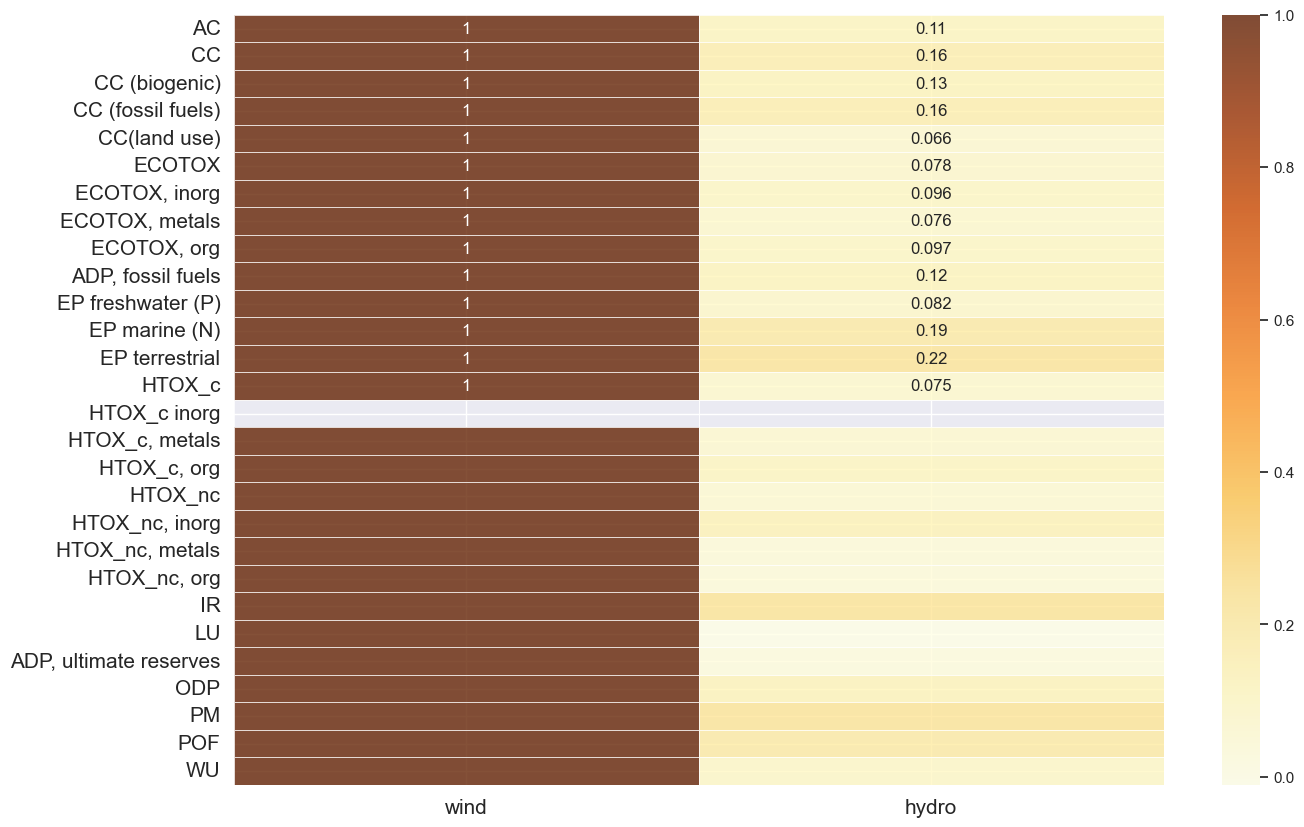

In [92]:
fig, axes = plt.subplots(figsize=(15,10))
sns.set_style("darkgrid")
sns.heatmap(df_norm.T,annot = True, cbar = True, ax=axes, cmap='YlOrBr', alpha=0.8, linewidth=0.5, xticklabels=True)
axes.set_yticklabels(short_names, rotation=0, fontsize=15)
axes.set_xticklabels(df_results.columns, rotation=0, fontsize=15)
# plt.savefig("./outputs/" + "heatmap_example.png", dpi=600) #to save the plot
plt.show()

**Back to [table of contents](#section0)?**
***

<a id='section6'></a>
# 6. Basic contribution analysis

Let's have a bit of a closer look at the inventory and the contributions of individual exchanges/activities!

But before that, we recalculate our inventory:

In [146]:
random_act = db_background.random()

In [147]:
random_act

'market for electricity, low voltage' (kilowatt hour, HR, None)

## 6.1 Recalculation of the inventory

In [148]:
functional_unit = {random_act:1}
lca = bc.LCA(functional_unit, ipcc2021)
lca.lci()
lca.lcia()

In [149]:
print("The {} process accounts for {:f} {}.".format(
    list(functional_unit.keys())[0]['name'],
    lca.score,
    bd.methods.get(ipcc2021).get('unit')
    ))

The market for electricity, low voltage process accounts for 0.445031 kg CO2-Eq.


And now over to the contribution analysis. Let's find the most damaging activities and biosphere flows.

## 6.2 Basic contribution analysis

In [150]:
import bw2analyzer as bwa

In [151]:
print(bwa.__version__)

(0, 10)


In [152]:
ca = bwa.ContributionAnalysis()
ca.annotated_top_processes(lca, limit=5) #returns a list of tuples: (lca score, supply amount, activity name)

[(0.09420961609526363,
  0.07342749716819962,
  'electricity production, lignite' (kilowatt hour, BA, None)),
 (0.0712293934825583,
  0.0756045299937369,
  'electricity production, hard coal' (kilowatt hour, HR, None)),
 (0.03776461298834243,
  0.08314825371261554,
  'heat and power co-generation, natural gas, combined cycle power plant, 400MW electrical' (kilowatt hour, HR, None)),
 (0.03763898096002305,
  0.03224320387323843,
  'electricity production, lignite' (kilowatt hour, SI, None)),
 (0.02170863120632956,
  0.016001696932088173,
  'electricity production, lignite' (kilowatt hour, HU, None))]

We can also set a limit below one, which will filter by fraction of impact instead of number of activities; we can also return activity keys instead of names.

In [153]:
#change "False" to "True" and this command will give a similar result as the following one, only that we set a limit here
ca.annotated_top_processes(lca, names=False, limit=0.05, limit_type='percent')

[(0.09420961609526363,
  0.07342749716819962,
  ('ecoinvent 3.9.1_cutoff', 'b89f9da3aa09347e74936869b6cb78f9')),
 (0.0712293934825583,
  0.0756045299937369,
  ('ecoinvent 3.9.1_cutoff', 'a1445ce2d21bdc4c646c1fb530588f27')),
 (0.03776461298834243,
  0.08314825371261554,
  ('ecoinvent 3.9.1_cutoff', '620a40318d5a833620384fa25a20006d')),
 (0.03763898096002305,
  0.03224320387323843,
  ('ecoinvent 3.9.1_cutoff', 'cd83853ec219e02312549130d3885304'))]

One very useful method to quickly analyze the contribution is the 'bwa.print_recursive_calculation()' which is really easy-to-use : 

In [154]:
bwa.print_recursive_calculation(random_act,ipcc2021,max_level=3,cutoff=0.01)

Fraction of score | Absolute score | Amount | Activity
0001 | 0.445 |     1 | 'market for electricity, low voltage' (kilowatt hour, HR, None)
  0.0109 | 0.004847 | 8.74e-08 | 'market for distribution network, electricity, low voltage' (kilometer
    0.0109 | 0.004847 | 8.74e-08 | 'distribution network construction, electricity, low voltage' (kilomet
  0.0355 | 0.01582 | 0.03554 | 'market for electricity, low voltage' (kilowatt hour, HR, None)
    0.0338 | 0.01506 | 0.03528 | 'electricity voltage transformation from medium to low voltage' (kilow
      0.0338 | 0.01506 | 0.03663 | 'market for electricity, medium voltage' (kilowatt hour, HR, None)
  0.952 | 0.4237 | 0.9928 | 'electricity voltage transformation from medium to low voltage' (kilow
    0.952 | 0.4237 | 1.031 | 'market for electricity, medium voltage' (kilowatt hour, HR, None)
      0.938 | 0.4174 | 1.031 | 'electricity voltage transformation from high to medium voltage' (kilo


Another way of listing the most contributing activities is this:

In [155]:
lca.top_activities() #this command essentially relies on the annotated_top_process command from above. Hence, the output is given as (lca score, supply amount, activity name)

[(0.09420961609526363,
  0.07342749716819962,
  'electricity production, lignite' (kilowatt hour, BA, None)),
 (0.0712293934825583,
  0.0756045299937369,
  'electricity production, hard coal' (kilowatt hour, HR, None)),
 (0.03776461298834243,
  0.08314825371261554,
  'heat and power co-generation, natural gas, combined cycle power plant, 400MW electrical' (kilowatt hour, HR, None)),
 (0.03763898096002305,
  0.03224320387323843,
  'electricity production, lignite' (kilowatt hour, SI, None)),
 (0.02170863120632956,
  0.016001696932088173,
  'electricity production, lignite' (kilowatt hour, HU, None)),
 (0.020352711986538926,
  0.015550518151799376,
  'electricity production, lignite' (kilowatt hour, RS, None)),
 (0.014341414981168575,
  0.02479049781764344,
  'heat and power co-generation, natural gas, conventional power plant, 100MW electrical' (kilowatt hour, HR, None)),
 (0.009348194871440105,
  0.0005358053220016957,
  'natural gas venting from petroleum/natural gas production' (cubi

This is where `lca_algebraic` becomes very useful, for its helping functions. Here is an example of a function to explore the impacts of an activity, and gather all the data in one nice dataframe, that we can plot easily.

> **MAJ : this function has been removed in the new update (lca_algebraic, version 1.1, April 2024). Why ???**

In [156]:
from lca_algebraic import *

In [157]:
printAct(random_act)

market for electricity, low voltage[HR] (0.035539 kilowatt hour)  \
                                                                                                          input   
Sulfur hexafluoride                                                           Sulfur hexafluoride                 
distribution network, electricity, low voltage  market for distribution network, electricity, ...                 
electricity, low voltage                        electricity production, photovoltaic, 3kWp sla...                 
electricity, low voltage#1                      electricity production, photovoltaic, 3kWp sla...                 
electricity, low voltage#2                      electricity voltage transformation from medium...                 
sulfur hexafluoride, liquid                           market for sulfur hexafluoride, liquid[RER]                 

                                                                         
                                                  amount           unit  
Sulfur hexafluoride                                  0.0       kilogram  
distribution network, electricity, low voltage       0.0      kilometer  
electricity, low voltage                         0.00394  kilowatt hour  
electricity, low voltage#1                      0.003283  kilowatt hour  
electricity, low voltage#2                      0.992776  kilowatt hour  
sulfur hexafluoride, liquid                          0.0       kilogram

In [158]:
df_contribution = exploreImpacts(ipcc2021, random_act)
df_contribution

market for electricity, low voltage[HR] (0.035539 kilowatt hour)  \
                                                                                                          input   
Sulfur hexafluoride                                                           Sulfur hexafluoride                 
distribution network, electricity, low voltage  market for distribution network, electricity, ...                 
electricity, low voltage                        electricity production, photovoltaic, 3kWp sla...                 
electricity, low voltage#1                      electricity production, photovoltaic, 3kWp sla...                 
electricity, low voltage#2                      electricity voltage transformation from medium...                 
sulfur hexafluoride, liquid                           market for sulfur hexafluoride, liquid[RER]                 

                                                                    
                                                  amount    impact  
Sulfur hexafluoride                                  0.0  0.000158  
distribution network, electricity, low voltage       0.0  0.004847  
electricity, low voltage                         0.00394  0.000245  
electricity, low voltage#1                      0.003283  0.000235  
electricity, low voltage#2                      0.992776  0.423729  
sulfur hexafluoride, liquid                          0.0  0.000001

In [159]:
share=pd.DataFrame(index=df_contribution.index, data={random_act['name']:df_contribution.iloc[:,2].values})
share

,"market for electricity, low voltage"
Sulfur hexafluoride,0.000158
"distribution network, electricity, low voltage",0.004847
"electricity, low voltage",0.000245
"electricity, low voltage#1",0.000235
"electricity, low voltage#2",0.423729
"sulfur hexafluoride, liquid",0.000001


C:\Users\TL268686\AppData\Local\Temp\ipykernel_20872\1660463015.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.round(share.sum()[0],3),


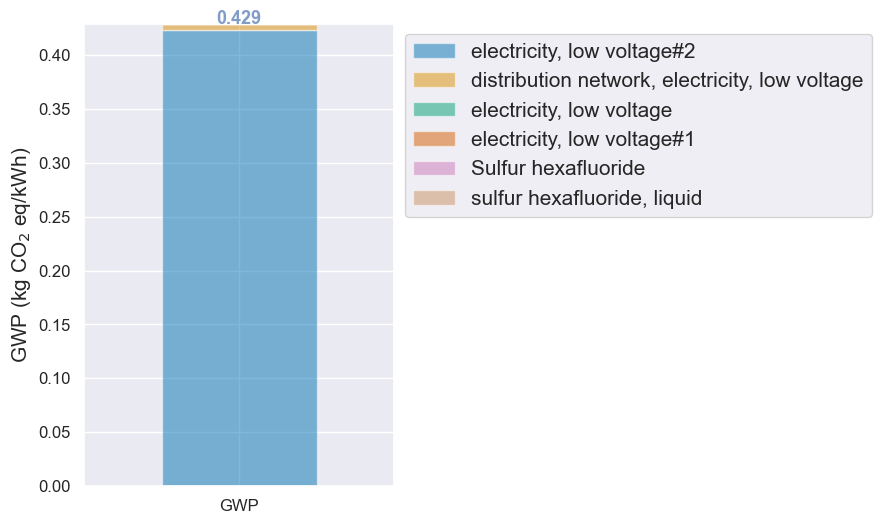

In [160]:
figure,ax1=plt.subplots(figsize=(4,6))
plt.subplots_adjust(wspace=0.3,hspace=0.3)
sns.set()
sns.set_style('darkgrid')
# ax1.boxplot(result_mc.T['CC'], whis=[0,100],showmeans=False,positions=[0],showfliers=False) #for uncertainty analysis
share.sort_values(by=random_act['name'], ascending=False).T.plot.bar(stacked=True,rot=0,color=colors,alpha=0.5,ax=ax1,fontsize=12, legend=None)
ax1.set_ylabel('GWP (kg CO$_2$ eq/kWh)', fontsize=15)
ax1.set_xticklabels(['GWP'])

bar_height1=[] ; bar_height2=[] 
for bar1 in ax1.patches:
    bar_height1.append(bar1.get_height())
ax1.text(
    ax1.patch.get_x(),
    ax1.patch.get_y() + sum(bar_height1),
    np.round(share.sum()[0],3),
    ha='center',
    color='b',
    weight='bold',
    alpha=0.7,
    size=13
)

ax1.legend(fontsize=15,bbox_to_anchor=(1,1))
# plt.savefig('Cradle-to-Gate_LCA_Contribution_GWP.png', dpi=600, bbox_inches='tight')
plt.show()

## 6.3 Top emissions and processes by name

In addition to the basic contribution analysis, we can also look at individual activities (columns) or flows (rows).

What if we want to group names together, i.e. to get the total impact for all "phosphates"? There isn't a built-in function for this, but it is relatively easy to do. Let's start with creating different lists:

In [165]:
from collections import defaultdict

functional_unit = {random_act:1}
lca = bc.LCA(functional_unit, ipcc2021)
lca.lci()
lca.lcia()

#get the scores for all biosphere flows of the same name
all_unique_names_and_their_scores = {
    name: [lca.characterized_inventory[row, :].sum() for row in rows]
    for name, rows in all_unique_names_and_their_rows.items()
}

all_unique_names_and_their_scores

{'Bromopropane': [0.0, 0.0],
 'Fenbuconazole': [0.0],
 'Kaolinite': [0.0],
 'Strontium-89': [0.0],
 'Azoxystrobin': [0.0, 0.0, 0.0, 0.0, 0.0],
 'Pendimethalin': [0.0, 0.0, 0.0, 0.0],
 'Silicon': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'Triadimenol': [0.0],
 'Phenol': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'Lithium I': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'Acetamide': [0.0, 0.0],
 'Protactinium-234': [0.0, 0.0],
 'Teflubenzuron': [0.0, 0.0, 0.0, 0.0],
 'Chlorine': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'Butadiene': [0.0, 0.0],
 'Caesium': [0.0, 0.0],
 'Hypochlorite': [0.0, 0.0, 0.0],
 'Hydrogen': [0.0, 0.0, 0.0, 0.0],
 'Transformation, from cropland fallow (non-use)': [0.0],
 'Potassium-40': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'Benzaldehyde': [0.0, 0.0, 0.0, 0.0],
 'Energy, gross calorific value, in biomass, primary forest': [0.0],
 '2,4-DB': [0.0, 0.0, 0.0, 0.0],
 'Carfentrazone-ethyl': [0.0, 0.0, 0.0, 0.0, 0.0],
 'Methane, tetrachloro-, R-10': [2.08806026525546

Now, let's sort this list by the score and only display the first 10 results.

In [167]:
#get the first 10 scores of the most contributing biosphere flows
sorted_scores = sorted(
    [(sum(scores), name) for name, scores in all_unique_names_and_their_scores.items()], 
    reverse=True
)

sorted_scores[:10]

[(0.4094278945509036, 'Carbon dioxide, fossil'),
 (0.024807188632007447, 'Methane, fossil'),
 (0.0047356649040147655, 'Dinitrogen monoxide'),
 (0.0033768110567258796, 'Sulfur hexafluoride'),
 (0.002269360571525958, 'Methane, non-fossil'),
 (0.00016242349837344356, 'Carbon dioxide, from soil or biomass stock'),
 (0.00011685743103407923, 'Methane, trifluoro-, HFC-23'),
 (9.939360820747614e-05, 'Methane, tetrafluoro-, R-14'),
 (1.2144603027590638e-05, 'Ethane, hexafluoro-, HFC-116'),
 (7.178145740432447e-06, 'Methane, chlorodifluoro-, HCFC-22')]

We can also encapsulate all this functionality in a single function.

In [168]:
from collections import defaultdict

def top_emissions_by_name(lca, biosphere_database='biosphere3'):
    names = defaultdict(list)

    for flow in bd.Database("biosphere3"):
        if flow.key in lca.biosphere_dict:
            names[flow['name']].append(
                lca.characterized_inventory[lca.biosphere_dict[flow.key], :].sum()
            )
    
    return sorted(
        [(sum(scores), name) for name, scores in names.items()], 
        reverse=True
    )

In [169]:
top_emissions_by_name(lca)[:5]

[(0.40942789455090356, 'Carbon dioxide, fossil'),
 (0.02480718863200745, 'Methane, fossil'),
 (0.0047356649040147655, 'Dinitrogen monoxide'),
 (0.0033768110567258796, 'Sulfur hexafluoride'),
 (0.002269360571525958, 'Methane, non-fossil')]

We can see that this function also groups emissions according to their type, e.g. all fossil carbon dioxide emissions are summed to "Carbon dioxide, fossil", as compared to the command in the top `ca.annotated_top_emissions`.

**Continue, or back to [table of contents](#section0)?**
***

<a id='section7'></a>
# 7. Monte Carlo simulation

According to British statistician George Cox "all models are wrong but some are useful" - in that light, quantifying uncertainty makes LCA results more reliable/robust. One of the easiest/ most common ways to do so is to perform a [Monte Carlo simulation](https://en.wikipedia.org/wiki/Monte_Carlo_method), a random sampling technique. Before elaborating on that, we need to understand how uncertainty information is stored in Brightway:

## 7.1 Uncertainty information in Brightway

Uncertainty is stored at the level of the exchanges - remember this! So, let's have a look at a random ecoinvent exchange:

In [170]:
random_act

'market for electricity, low voltage' (kilowatt hour, HR, None)

In [171]:
[exc for exc in random_act.exchanges()][0].as_dict()

{'flow': 'd69294d7-8d64-4915-a896-9996a014c410',
 'type': 'production',
 'name': 'electricity, low voltage',
 'classifications': {'CPC': ['17100: Electrical energy']},
 'production volume': 10553823341.8264,
 'properties': {'carbon allocation': {'amount': 0.0, 'unit': 'kg'},
  'carbon content': {'amount': 0.0, 'unit': 'dimensionless'},
  'price': {'amount': 0.107,
   'unit': 'EUR2005',
   'comment': 'Temporary price data. Calculated as 90% of purchasers price based on: IEA Key world energy statistics 2004 (www.iea.org/textbase/nppdf/free/2004/keyworld2004.pdf)'}},
 'activity': '7928c3f4-e6f2-5ad5-97c3-176f29b6824e',
 'unit': 'kilowatt hour',
 'amount': 1.0,
 'uncertainty type': 0,
 'loc': 1.0,
 'input': ('ecoinvent 3.9.1_cutoff', 'cc233fdf0c4d968e308041059ef87080'),
 'output': ('ecoinvent 3.9.1_cutoff', 'cc233fdf0c4d968e308041059ef87080')}

The *necessary* uncertainty information of an exchange is described in the following fields:  
  - **'uncertainty type'** : type of probability distribution function that the exchange follows. For example, the uncertainty type = 2 indicates a `lognormal`  distribution.  
  - **'loc', 'scale', 'shape', 'minimum', 'maximum'**: parameters of the distribution function, which are respectively the location (mean $\mu$, mode, offset, or median), scale (e.g. standard deviation $\sigma$), and shape as well as minimum and maximum of the underlying distribution. Mind that different distribution functions require different parameters - not all parameters have to be defined for each distribution.

Some *additional* uncertainty related information ('scale without pedigree', 'pedigree') are also there, but are not directly used in the calculation of the uncertainty. They are also specific to ecoinvent.

Uncertainty in Brightway is dealt with using a Python package called `stats_arrays` (see [here](http://stats-arrays.readthedocs.io/en/latest/)), developed by Chris Mutel in the context of the development of Brightway but applicable to any stochastic model in Python. Have a look at it to see which probability distribution functions are available. And then, let's import this package!

In [172]:
import stats_arrays

Just to give a brief example of how the uncertainty information "works", let's have a look at the lognormal distribution. As a reminder:   
  - a random variable $X$ is a lognormal if its natural logarithm $ln(X)$ is normally distributed  
  - the natural logarithm of the *median* of the lognormal distribution is equal to the median (=mean) of the underlying distribution  

Taking the deterministic amount `amount` to be the median, we should have `loc` = `ln('amount')`. Let's do this for the first exchange of a random ecoinvent activity that has a lognormal distribution.  
>You can check it by lookiing at the uncertainty type in the activity

In [173]:
random_act.as_dict()

{'comment': "This is a market activity. Each market represents the consumption mix of a product in a given geography, connecting suppliers with consumers of the same product in the same geographical area. Markets group the producers and also the imports of the product (if relevant) within the same geographical area. They also account for transport to the consumer and for the losses during that process, when relevant.\nThis dataset describes the electricity available on the high voltage level in Croatia. This is done by showing the transmission of 1kWh electricity at high voltage.\nTechnology:  Average technology used to transmit and distribute electricity. Includes underground and overhead lines, as well as air-, vacuum- and SF6-insulated high-to-medium voltage switching stations. Electricity production according to related technology datasets.\nTime period:  The 'Start of Period' and 'End of Period' do not refer to the year for which this market is valid. See general comment for the y

## 7.2 Basic Monte Carlo simulation

**One functional unit, one impact category**

In [174]:
#MC simulation with 10 iterations for our banana production and the IPCC GWP100a method
mc = bc.MonteCarloLCA({random_act:1},  ipcc2013)
scores = [next(mc) for _ in range(10)]
scores

#or this way:
#for _ in range(10):
#    print(next(mc))

[0.458639708672316,
 0.47596898378381003,
 0.48616994512105793,
 0.4285418392539535,
 0.45969324770962655,
 0.46412307967423116,
 0.4929023647775486,
 0.4854437334615479,
 0.4428084078018661,
 0.4862505717016432]

Let's print the results of our MC:

(array([1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 3., 0., 0., 0., 1.]),
 array([0.42854184, 0.43015085, 0.43175987, 0.43336888, 0.43497789,
        0.4365869 , 0.43819592, 0.43980493, 0.44141394, 0.44302296,
        0.44463197, 0.44624098, 0.44785   , 0.44945901, 0.45106802,
        0.45267704, 0.45428605, 0.45589506, 0.45750408, 0.45911309,
        0.4607221 , 0.46233112, 0.46394013, 0.46554914, 0.46715815,
        0.46876717, 0.47037618, 0.47198519, 0.47359421, 0.47520322,
        0.47681223, 0.47842125, 0.48003026, 0.48163927, 0.48324829,
        0.4848573 , 0.48646631, 0.48807533, 0.48968434, 0.49129335,
        0.49290236]),
 <BarContainer object of 40 artists>)

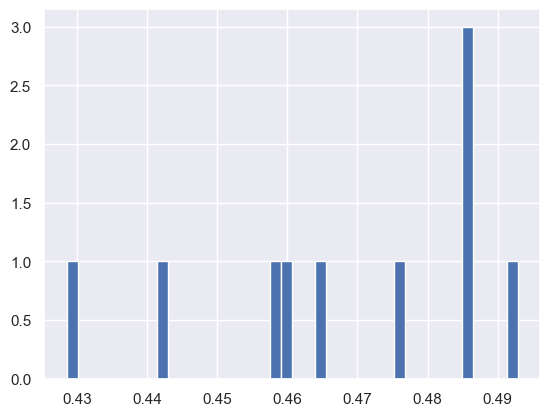

In [175]:
plt.hist(scores,bins=40)

Well, this doesn't really look like anything yet. We should increase the number of iterations - which yields more robust results. Around 10,000 iterations is a good starting point. However, this takes a while, so we will just give it a try with 1000 now. See for yourself how long it would take for a higher number of iterations.

In [176]:
#define the number of iterations
n_runs = 50

In [177]:
%%time
values = [next(mc) for _ in range(n_runs)]

CPU times: total: 18min 2s
Wall time: 4min 54s


(array([2., 1., 0., 0., 0., 0., 2., 3., 3., 1., 2., 1., 7., 0., 3., 6., 3.,
        3., 9., 5., 4., 6., 7., 6., 5., 2., 3., 1., 0., 3., 0., 4., 1., 1.,
        2., 0., 2., 0., 0., 2.]),
 array([0.42684449, 0.42903839, 0.43123229, 0.4334262 , 0.4356201 ,
        0.437814  , 0.4400079 , 0.44220181, 0.44439571, 0.44658961,
        0.44878351, 0.45097742, 0.45317132, 0.45536522, 0.45755912,
        0.45975303, 0.46194693, 0.46414083, 0.46633473, 0.46852864,
        0.47072254, 0.47291644, 0.47511034, 0.47730425, 0.47949815,
        0.48169205, 0.48388595, 0.48607986, 0.48827376, 0.49046766,
        0.49266156, 0.49485547, 0.49704937, 0.49924327, 0.50143717,
        0.50363108, 0.50582498, 0.50801888, 0.51021278, 0.51240669,
        0.51460059]),
 <BarContainer object of 40 artists>)

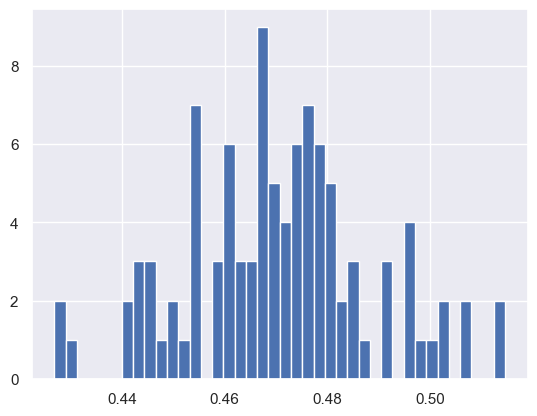

In [178]:
plt.hist(values, bins=40)

We can also **run the MCs in parallel** which speeds up the computation time - see the following and compare the calculation times!

In [179]:
# We can also create parallel Monte Carlo that will run simultations on multiple workers simultaneoulsy
bc.ParallelMonteCarlo?

Init signature:
bc.ParallelMonteCarlo(
    demand,
    method,
    iterations=1000,
    chunk_size=None,
    cpus=None,
    log_config=None,
)
Docstring:      Split a Monte Carlo calculation into parallel jobs
File:           c:\users\tl268686\appdata\local\anaconda3\envs\cours\lib\site-packages\bw2calc\monte_carlo.py
Type:           type
Subclasses:     

In [180]:
pmc = bc.ParallelMonteCarlo(mc.demand, mc.method, iterations=n_runs)

In [181]:
%%time
values = pmc.calculate()

CPU times: total: 78.1 ms
Wall time: 3min 37s


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         3.,  5.,  4.,  3., 11.,  9.,  8., 15., 15., 10.,  6.,  6.,  5.,
         3.]),
 array([0.30407728, 0.30912398, 0.31417068, 0.31921738, 0.32426409,
        0.32931079, 0.33435749, 0.33940419, 0.34445089, 0.34949759,
        0.3545443 , 0.359591  , 0.3646377 , 0.3696844 , 0.3747311 ,
        0.3797778 , 0.3848245 , 0.38987121, 0.39491791, 0.39996461,
        0.40501131, 0.41005801, 0.41510471, 0.42015142, 0.42519812,
        0.43024482, 0.43529152, 0.44033822, 0.44538492, 0.45043163,
        0.45547833, 0.46052503, 0.46557173, 0.47061843, 0.47566513,
        0.48071184, 0.48575854, 0.49080524, 0.49585194, 0.50089864,
        0.50594534]),
 <BarContainer object of 40 artists>)

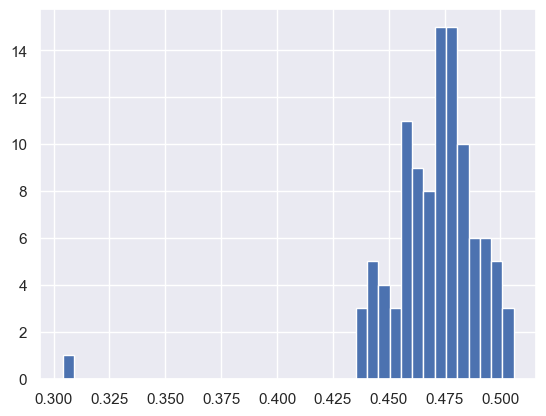

In [182]:
plt.hist(values, bins=40)

**One functional unit, multiple impact categories**

In [183]:
# define the function for MC simulation
def multiImpactMonteCarloLCA(functional_unit, list_methods, iterations):
    # Step 1
    MC_lca = bc.MonteCarloLCA(functional_unit)
    MC_lca.lci()
    # Step 2
    C_matrices = {}
    # Step 3
    for method in list_methods:
        MC_lca.switch_method(method)
        C_matrices[method] = MC_lca.characterization_matrix
    # Step 4
    results = np.empty((len(list_methods), iterations))
    # Step 5
    for iteration in range(iterations):
        next(MC_lca)
        for method_index, method in enumerate(list_methods):
            results[method_index, iteration] = (C_matrices[method]*MC_lca.inventory).sum()
    return results

# define the LCIA methods, functional unit, and the number of iterations
list_methods=[m for m in bd.methods if 'EF v3' in str(m) and 'no LT' not in str(m) and 'EN15' not in str(m)]
fu = {random_act:1}
iterations = 100

# let it run!
test_results = multiImpactMonteCarloLCA(fu, list_methods, iterations)
test_results

array([[5.52925207e-03, 5.39892709e-03, 5.30676216e-03, ...,
        5.33759278e-03, 5.45583740e-03, 5.64012425e-03],
       [4.67560356e-01, 4.72314519e-01, 4.63945987e-01, ...,
        4.67512520e-01, 4.89040014e-01, 4.77747817e-01],
       [1.51205008e-03, 3.86556717e-03, 3.88867963e-03, ...,
        2.41596367e-03, 5.56686735e-03, 2.16766481e-03],
       ...,
       [1.20814209e-08, 1.40081745e-08, 1.07567942e-08, ...,
        1.25319408e-08, 1.40166169e-08, 1.15211596e-08],
       [1.48907005e-03, 1.75169613e-03, 1.62806039e-03, ...,
        1.59961484e-03, 1.84575500e-03, 1.60839977e-03],
       [5.53717081e-01, 4.66736852e-01, 3.77845948e-01, ...,
        4.93102002e-01, 5.56530913e-01, 4.40228652e-01]])

(array([2., 3., 3., 2., 2., 5., 4., 7., 6., 5., 9., 5., 6., 7., 3., 6., 3.,
        3., 3., 4., 1., 3., 3., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1.]),
 array([0.44079095, 0.44397546, 0.44715996, 0.45034447, 0.45352897,
        0.45671348, 0.45989798, 0.46308249, 0.46626699, 0.4694515 ,
        0.472636  , 0.47582051, 0.47900501, 0.48218952, 0.48537402,
        0.48855853, 0.49174303, 0.49492754, 0.49811204, 0.50129655,
        0.50448105, 0.50766556, 0.51085006, 0.51403457, 0.51721907,
        0.52040358, 0.52358808, 0.52677259, 0.52995709, 0.5331416 ,
        0.5363261 , 0.53951061, 0.54269511, 0.54587962, 0.54906412,
        0.55224863, 0.55543313, 0.55861764, 0.56180214, 0.56498665,
        0.56817115]),
 <BarContainer object of 40 artists>)

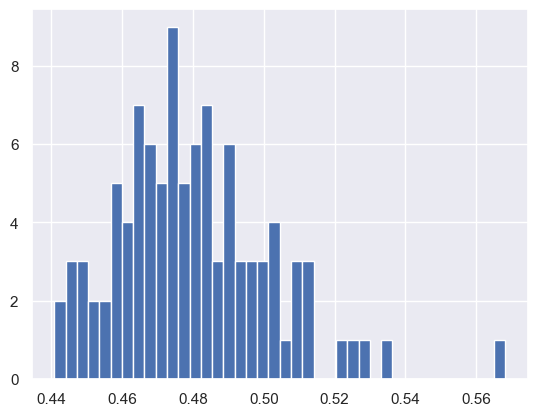

In [184]:
#we can get the plots for all 34 ILCD methods (--> type: len(ILCD)) by changing the index in the brackets
plt.hist(test_results[1], bins=40)

---

At this point, it's worth pointing again at the **[Activity browser](https://github.com/LCA-ActivityBrowser/activity-browser)** and **[lca_algebraic](https://github.com/oie-mines-paristech/lca_algebraic/)**. These two Brightway2-extensions serve different purposes and require different settings, so check them out if you're curious.

---

**Back to [table of contents](#section0)?**
***